## The U.S. Memories

Отрасль по производству полупроводников была безубыточной в 1970х годах и не было нужды в аналитики. Но в 1980х на рынок пришли японские и корейские полупроводники. Для победы на рынке нужны были средства, которые обеспечат лидерство, простых инвестиций уже не хватало.

Аналитика "по факту", когда товар уже в продаже, не подходила для производителя. Производитель захотел понимать конкурентноспособность товара до его выпуска

Данная аналитика берет свое начало с 1989 года, когда PWC завершила конкурентный анализ DRAM производства, а Япония захватила 15% рынка малой ёмкости и 40% рынка высокой ёмкости.

PWC оценила IBM, ADM, Digital, Intel, National Semilicon. Целью оценки компаний являлась задача по определении конкрунтного приемущества и вытеснения японских компаний с рынка.

Позже McKinsey была привлечена к этой работе.


### Рынок на данный момент

![title](img/EBIDA.png)

![title](img/EBIDA_by_companies.png)

![title](img/dram.png)

![title](img/dram_nand.png)

![title](img/nanos.png)

К 1993 году компания PWC должна была разработать сценарий конкуренции, но.... ?

![title](img/products.png)

## Теперь поработаем мы

In [2]:
#проверка существования библиотек и их импорт, в случае отсутствия
from pip._internal import main
#используемые библиотеки
packages = ('numpy', 
            'pandas',
            'pandas_profiling',
            'sklearn',
            'seaborn',
            'catboost',
            'xgboost')

#проверка на доступность импорта, если нет, то устанавливаем библиотеку
def checkInstall(packages):
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            main(['install', package.split()[0]])

checkInstall(packages)

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as ppf
#import featuretools as ft
from itertools import chain

#boostings
import xgboost as xgb
import catboost as ctb

#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier #либо ExtraTree
# from imblearn.under_sampling import TomekLinks
# memory management
import gc

#appendix
%matplotlib inline
warnings.filterwarnings('ignore')

## Main functions

In [3]:
class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------
        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features
        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients
        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=1, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)
        Parameters 
        --------
        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True
        task : string
            The machine learning task, either 'classification' or 'regression'
        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs
        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = xgb.XGBClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.
        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 
        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.
        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances
        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

In [4]:
def xgbfit(alg, train, test, y_train, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=100):
    '''
    Для XGBoost
    '''
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data = train.values, label=y_train, feature_names=train.columns)
        xgtest = xgb.DMatrix(data = test.values, label=y_test, feature_names=train.columns)
        cvresult = xgb.cv(xgb_param, \
                          xgtrain, \
                          num_boost_round=alg.get_params()['n_estimators'], \
                          nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, \
                          show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(train.values, y_train, eval_metric='auc')   
    dtrain_predictions = alg.predict(test.values)
    dtrain_predprob = alg.predict_proba(test.values)[:,1]
        
    print("==========> TRAIN & CV <===============")
    print ('{} roc_auc '.format(roc_auc_score(y_test.values, dtrain_predprob)))
    
    return alg




def catfit(alg, train, test, y_train, y_test, useTrainCV=True, cv_folds=3):
    '''
    Для CatBoost
    '''
    if useTrainCV:  
        ctb_param = alg.get_params()
        cttrain = ctb.Pool(data = train.values, label=y_train, feature_names=list(train.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cttest = ctb.Pool(data = test.values, label=y_test, feature_names=list(train.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cvresult = ctb.cv(cttrain, \
                          ctb_param, \
                          nfold=cv_folds,
                          verbose_eval = 100)
    
    alg.fit(train.values, y_train)
        
    dtrain_predictions = alg.predict(test.values)
    dtrain_predprob = alg.predict_proba(test.values)[:,1]
        
    print("==========> TRAIN & CV <===============")
    print ('{} roc_auc '.format(roc_auc_score(y_test.values, dtrain_predprob)))
    
    return alg

# вы уже придумали, как можно сделать универсально?

In [5]:

def mem_usage(obj):
    """    
    input: pd.DataFrame | pd.Series
    
    return: sting
    """
    #если DataFrame
    if isinstance(obj, pd.DataFrame):
        usage_b = obj.memory_usage(deep = True).sum()
    #если Series
    else:
        usage_b = obj.memory_usage(deep = True)
    usage_mb = usage_b / 1024 ** 2 # в МБ
    return "{:03.2f} MB".format(usage_mb)


def replace_cat(obj, float_cols, min_value=0.001, features=None):
    """
    Объекты в категории
    
    input: pd.DataFrame | pd.Series
    input: hasattr(features, '__iter__')
    input: .0 =< min_value >= 1.
    
    return pd.DataFrame | pd.Series
    """
    #только с DataFrame
    if isinstance(obj, pd.DataFrame):
        converted_obj = pd.DataFrame()
        if not features: features = obj.columns
        #обзор колонок
        for col in features:
            if col not in float_cols:
                num_unique_values = len(obj[col].unique())
                num_total_values = len(obj[col])
                #если % меньше
                if num_unique_values / num_total_values < min_value:
                    converted_obj.loc[:,col] = obj[col].astype('category')
                else:
                    converted_obj.loc[:,col] = obj[col]
            else:
                converted_obj.loc[:,col] = obj[col]
                
        return converted_obj
    #если Series
    else:
        if col not in float_cols:
            num_unique_values = len(obj[col].unique())
            num_total_values = len(obj[col])
            #если % меньше
            if num_unique_values / num_total_values < min_value:
                return obj[col].astype('category')
            else:
                return obj[col]
        
        
def as_dict(frame):
    """
    перевод в словарь
    
    input: pd.DataFrame
    
    return dictionary
    """
    #процесс образования словаря
    dtypes = frame.dtypes
    dtypes_col = dtypes.index
    dtypes_type = [i.name for i in dtypes.values]
    column_types = dict(zip(dtypes_col, dtypes_type))
    return {key:value for key,value in list(column_types.items())}


def weight_reducer(frame, min_value=0.001, get_dict = None):
    """
    Основная функция редьюсера
    
    input: pd.DataFrame
    input: .0 =< min_value >= 1.
    input: get_dict == bool
    
    return pd.DataFrame  
    """
    #если это Frame
    if isinstance(frame, pd.DataFrame):
        before = mem_usage(frame)
        float_cols = []
        for dtype in set(frame.dtypes):
            if 'float' in str(dtype):
                cols = frame[[col for col in frame.columns if 'float' in str(frame[col].dtypes)]].select_dtypes(include = [dtype]).columns
                frame[cols] = frame[cols].select_dtypes(include = [dtype]). \
                              apply(pd.to_numeric, downcast='float')
                float_cols = cols
            if 'int' in str(dtype): 
                cols = frame[[col for col in frame.columns if 'int' in str(frame[col].dtypes)]].select_dtypes(include = [dtype]).columns
                frame[cols] = frame[cols].select_dtypes(include = [dtype]).\
                              apply(pd.to_numeric, downcast='unsigned')
            frame = replace_cat(frame, float_cols, min_value)
        after = mem_usage(frame)
        print('Columns - {}, early size - {}, replaced size - {}'.format(frame.shape[1], before, after))
        if get_dict: frame = as_dict(frame)
        return frame

### Работа с данными

In [6]:
dram_df = pd.read_csv('data/memories.csv', encoding = 'utf-8').drop('Time', axis = 1)
dram_df['target'] = dram_df['Pass/Fail']
dram_df.drop('Pass/Fail', axis = 1, inplace = True)
dram_df.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,target
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [7]:
#какая целевая переменная
print(dram_df['target'].mean())
print('% целевого = ', 1+dram_df['target'].mean())

-0.8672622846202935
% целевого =  0.13273771537970647


### Понимание данных

#### selector

In [8]:
fs = FeatureSelector(data = dram_df.drop('target', axis = 1), labels = dram_df['target'])

In [9]:
fs.identify_missing(missing_threshold=0.8)

8 features with greater than 0.80 missing values.



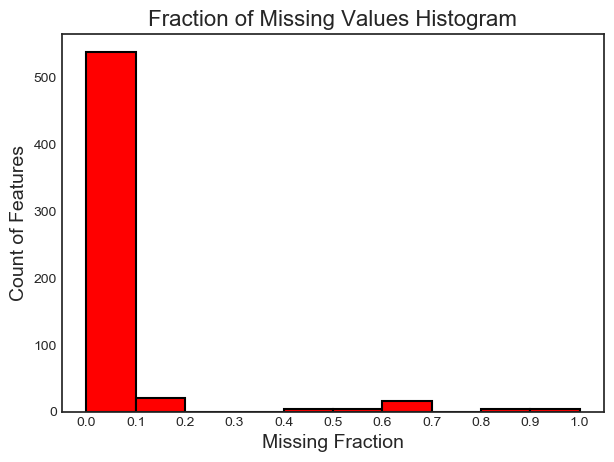

In [10]:
fs.plot_missing()

In [11]:
fs.identify_single_unique()

116 features with a single unique value.



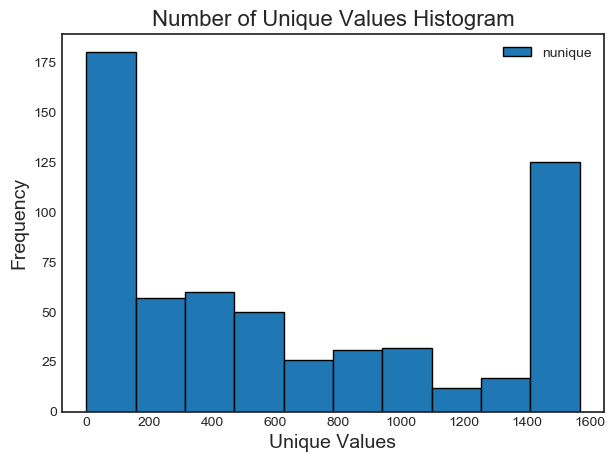

In [12]:
fs.plot_unique()

220 features with a correlation magnitude greater than 0.90.



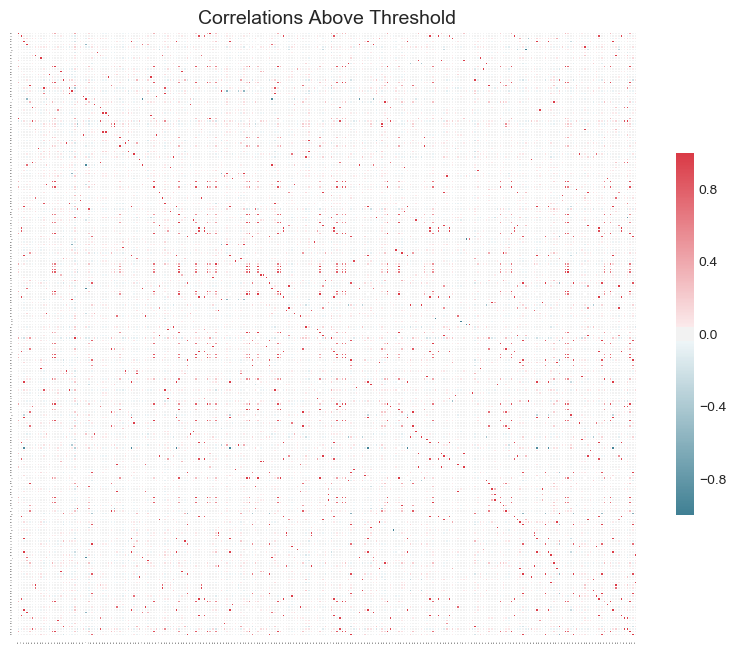

In [13]:
fs.identify_collinear(correlation_threshold=0.90)
fs.plot_collinear()

Training Gradient Boosting Model

[0]	validation_0-auc:0.699095
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.687632
[2]	validation_0-auc:0.678281
[3]	validation_0-auc:0.713726
[4]	validation_0-auc:0.739517
[5]	validation_0-auc:0.746455
[6]	validation_0-auc:0.744193
[7]	validation_0-auc:0.735143
[8]	validation_0-auc:0.733484
[9]	validation_0-auc:0.753846
[10]	validation_0-auc:0.759728
[11]	validation_0-auc:0.752187
[12]	validation_0-auc:0.745551
[13]	validation_0-auc:0.752036
[14]	validation_0-auc:0.744193
[15]	validation_0-auc:0.747964
[16]	validation_0-auc:0.753846
[17]	validation_0-auc:0.752338
[18]	validation_0-auc:0.751735
[19]	validation_0-auc:0.7454
[20]	validation_0-auc:0.747059
[21]	validation_0-auc:0.753695
[22]	validation_0-auc:0.776923
[23]	validation_0-auc:0.77451
[24]	validation_0-auc:0.768477
[25]	validation_0-auc:0.769683
[26]	validation_0-auc:0.809351
[27]	validation_0-auc:0.809351
[28]	validation_0-auc:0.800905
[29]	validation

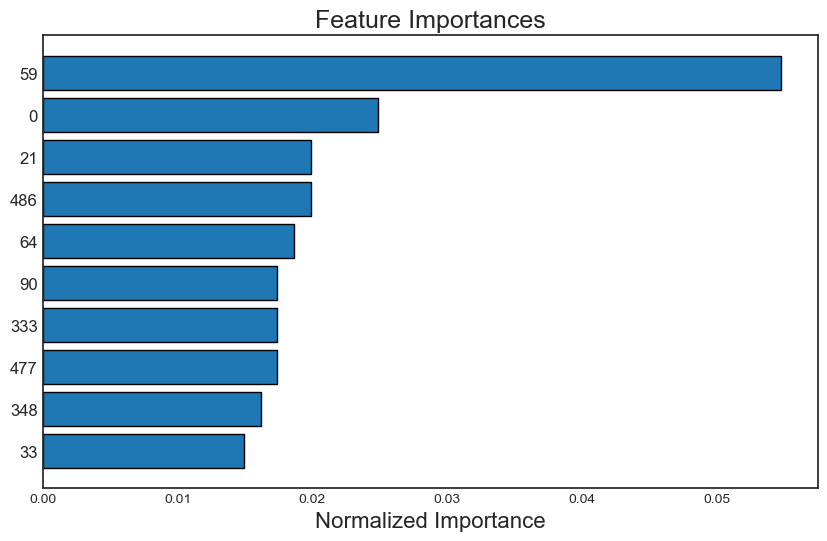

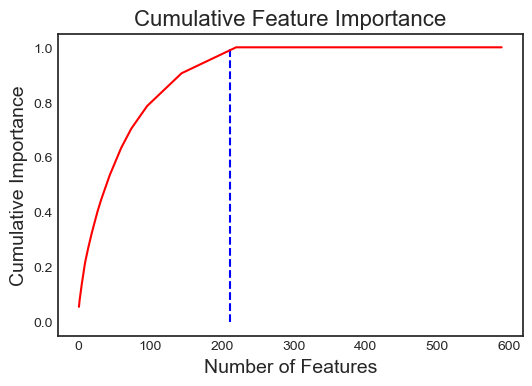

212 features required for 0.99 of cumulative importance


In [14]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 1, early_stopping = True)

fs.plot_feature_importances(threshold = 0.99, plot_n = 10)

In [15]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,59,0.054726,0.054726,0.054726
1,0,0.024876,0.024876,0.079602
2,21,0.019900,0.019900,0.099502
3,486,0.019900,0.019900,0.119403
4,64,0.018657,0.018657,0.138060
5,90,0.017413,0.017413,0.155473
6,333,0.017413,0.017413,0.172886
7,477,0.017413,0.017413,0.190299
8,348,0.016169,0.016169,0.206468
9,33,0.014925,0.014925,0.221393


In [16]:
fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

24 features with greater than 0.60 missing values.

116 features with a single unique value.

142 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

[0]	validation_0-auc:0.581101
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.564732
[2]	validation_0-auc:0.566964
[3]	validation_0-auc:0.568452
[4]	validation_0-auc:0.56715
[5]	validation_0-auc:0.563058
[6]	validation_0-auc:0.562314
[7]	validation_0-auc:0.55878
[8]	validation_0-auc:0.558036
[9]	validation_0-auc:0.559524
[10]	validation_0-auc:0.559524
[11]	validation_0-auc:0.542039
[12]	validation_0-auc:0.53311
[13]	validation_0-auc:0.532366
[14]	validation_0-auc:0.529204
[15]	validation_0-auc:0.529576
[16]	validation_0-auc:0.529948
[17]	validation_0-auc:0.528274
[18]	validation_0-auc:0.530134
[19]	validation_0-auc:0.528646
[20]	validation_0-auc:0.52939
[21]	validation_0-auc:0.529762
[22]	validation_0-auc:0.530506
[23]	validation_0-auc:0.530878
[24]	validation

### Profiling

In [17]:
ppf.ProfileReport(dram_df)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Что можно было бы сделать? 

In [ ]:
#что сделали бы "аналитики" без думно
#генерация и обзор фичей

In [18]:
#отражение в целевой переменной
dram_df.groupby('target')['0'].agg(['mean', 'max', 'min'])

,mean,max,min
target,,,
-1,3014.947316,3356.35,2743.24
1,3007.526250,3266.55,2848.46


In [19]:
#по всему столбцу
dram_df['0'].agg(['mean', 'max', 'min'])

mean    3014.452896
max     3356.350000
min     2743.240000
Name: 0, dtype: float64

Вот так точно не делаем

![title](img/one.png)

### Что нужно сделать

In [20]:
#найти особенность в 1 (принятых), какие переменные могут отражать модель бизнеса / модель производства

In [21]:
ppf.ProfileReport(dram_df[dram_df['target'] == 1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [22]:
fs.identify_all(selection_params = {'missing_threshold': 0.01, 'correlation_threshold': 0.90, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.90})

103 features with greater than 0.01 missing values.

116 features with a single unique value.

220 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

[0]	validation_0-auc:0.557212
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.554257
[2]	validation_0-auc:0.591593
[3]	validation_0-auc:0.595353
[4]	validation_0-auc:0.595085
[5]	validation_0-auc:0.599919
[6]	validation_0-auc:0.602605
[7]	validation_0-auc:0.597771
[8]	validation_0-auc:0.598979
[9]	validation_0-auc:0.606769
[10]	validation_0-auc:0.599517
[11]	validation_0-auc:0.594279
[12]	validation_0-auc:0.592802
[13]	validation_0-auc:0.592399
[14]	validation_0-auc:0.588638
[15]	validation_0-auc:0.6065
[16]	validation_0-auc:0.642224
[17]	validation_0-auc:0.642358
[18]	validation_0-auc:0.627988
[19]	validation_0-auc:0.626914
[20]	validation_0-auc:0.625034
[21]	validation_0-auc:0.62275
[22]	validation_0-auc:0.625436
[23]	validation_0-auc:0.62087
[24]	validatio

Используем категоризацию для получения комплексных данных и полного отражения

На пример:

#### Бостонская матрица (используется для uplift)

![title](img/Uplift_boston.png)

![title](img/uplf.png)

In [23]:
lgreg = LogisticRegression(penalty = 'l2', #для контроля за переобучением
                           C = 10.0 ,
                           solver = 'lbfgs', #подходит для регуляризации l2
                           max_iter = 150, #добавим 50 итераций к стандартному параметру, но выборка большая, можно не пименять
                           random_state = 28)

#### Ещё лучше вариант - насыщение рынка

![title](img/scurve.gif)

#### Новые категории

Не будем придумывать простые переменные, придумаем сложные (опять)

Матрица экрана бизнеса и переменные отаслевого анализа:
- Рыночные переменные (концентрация на рынке, соотношение к другим товарам, качество, ресурсы)
- Угрозы соперников (как внешние, как и внутренние)

![title](img/bus.png)

In [24]:
clf = RandomForestClassifier()

#### Ещё немного работы

In [25]:
tl = TomekLinks(random_state=28, return_indices=True)
x,y,idx = tl.fit_sample(dram_df[df.drop('boston', axis = 1).columns].fillna(0).values, 
                        dram_df['target'])
x.shape

NameError: name 'TomekLinks' is not defined

In [26]:
#### теперь категоризируем

In [27]:
mem_usage(dram_df)

'7.07 MB'

In [28]:
weight_reducer(dram_df).head()

Columns - 591, early size - 7.07 MB, replaced size - 3.54 MB


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,target
0,3030.929932,2564.000000,2187.733398,1411.126465,1.3602,100.0,97.613297,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.780029,2465.139893,2230.422119,1463.660645,0.8294,100.0,102.343300,0.1247,1.4966,-0.0005,...,208.204498,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.204498,-1
2,2932.610107,2559.939941,2186.411133,1698.017212,1.5102,100.0,95.487801,0.1241,1.4436,0.0041,...,82.860199,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.860199,1
3,2988.719971,2479.899902,2199.033203,909.792603,1.3204,100.0,104.236702,0.1217,1.4882,-0.0124,...,73.843201,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.843201,-1
4,3032.239990,2502.870117,2233.366699,1326.520020,1.5334,100.0,100.396698,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.843201,-1


In [29]:
print('Сравним объем занимаемой памяти')
print('XGB - ', mem_usage(X_test_xgb))
print('Cat - ', mem_usage(X_test_cat))

Сравним объем занимаемой памяти


NameError: name 'X_test_xgb' is not defined

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train_xgb, Y, test_size = 0.3)

alg_xgb = xgb.XGBClassifier(n_estimators=100)  
xgb_alg = xgbfit(alg_xgb, x_train, x_test, y_train, y_test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train_cat, Y, test_size = 0.3)

alg_ctb = ctb.CatBoostClassifier(n_estimators=100)  
cat_alg = catfit(alg_ctb, x_train, x_test, y_train, y_test)